## Description
---

This script is for plotting and comparing the TKE, MKE & EKE of/between HYCOM simluations and GlobCurrent.

The data used includes:
- the GlobCurrent surface data which includes the Ekman component; and
- HYCOM simulation velocity outputs interpolated to the GlobCurrent grid.

Details of the interpolation of HYCOM to GlobCurrent's grid can be found in the `VEL.ipynb` notebook in this directory.

Ulitmately, the calculations of TKE, MKE & EKE are based on the methods sent to me from Bjorn, below:

```
function [tke,mke,eke]=calc_kinetic(uin,vin)
% function [tke,mke,eke]=calc_kinetic(uin,vin)
%
% routine to calculate total kinetic energy (tke), kinetic energy of the mean flow (mke),
% and eddy kinetic energy (eke).
%
% tke can be split into mke and eke as follows:
% tke = mke + eke
%
% mke reflects the energy from the mean flow and eke reflects the energy from the
% mesoscale variability (eddies).
%
% applying Reynold's averaging: U = Ubar + U'
% where Ubar is the time mean of U, and U' the mesoscale deviations (U' = U - Ubar)
% the same applies for V
%
% mke = (Ubar*Ubar + Vbar*Vbar)/2
%
% eke = (U'U'bar + V'V'bar)/2
% because U'U'bar (the time mean of the velocity correlations) is difficult to calculate
% first calculate Ubar (time average U) and UUbar (time average U*U) and then
% U'U'bar = UUbar - Ubar*Ubar (same for V)
%

% calculate Ubar / Vbar
ubar=nanmean(uin,3);
vbar=nanmean(vin,3);

% calculate mke = (Ubar*Ubar + Vbar*Vbar)/2
mke=(ubar.*ubar+vbar.*vbar)./2;

% calculate UUbar and VVbar
uubar=nanmean(uin.*uin,3);
vvbar=nanmean(vin.*vin,3);

% calculate eke =  (U'U'bar + V'V'bar)/2
% where U'U'bar = UUbar - Ubar*Ubar
% and V'V'bar = VVbar - Vbar*Vbar
uprimeuprimebar=uubar-ubar.*ubar;
vprimevprimebar=vvbar-vbar.*vbar;
eke=(uprimeuprimebar+vprimevprimebar)./2;

% calculate tke
tke=mke+eke;
```

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import xarray as xr
import cmocean.cm as cmo
import cmcrameri.cm as cmc

In [2]:
plt.rcParams['figure.facecolor']='white'
plt.rcParams['axes.facecolor']='white'

In [5]:
def loadData(native=True):
    '''Load GlobCurrent and CMEMS velocity data. Also load model data in either
    'native' grid and resolution or on the GlobCurrent grid by setting
    'native=False'.
    
    Example usage: loadData(native=False)
    
    This function will also set a global variable that checks whether the model data
    currently loaded is in native resolution or not. This will help to ensure functions
    are always using the correct data.
    '''
    # Loading CMEMS and GlobCurrent data
    ds_cmems = xr.open_dataset('../Data/velocity/cmems_ssh.nc')
    ds_cmems = ds_cmems.sel(time=slice('2009-01-01','2014-06-04'))
    ds_cmems = ds_cmems.rename_vars({'ugos':'u', 'vgos': 'v'})
    
    ds_gc = xr.open_dataset('../Data/velocity/globcurrent_surface_regional.nc')
    ds_gc = ds_gc.sel(time=slice('2009-03','2012-02'))
    ds_gc = ds_gc.rename({'lon':'longitude', 'lat':'latitude'})
    ds_gc = ds_gc.rename_vars({'eastward_eulerian_current_velocity':'u',
                               'northward_eulerian_current_velocity': 'v'})
    
    # Set global variable to check which dataset is loaded
    global NATIVELOADED
    
    # Check to load at native or globcurrent resolution
    if native == True:
        print('Loading data at native resolution...')
        # Loading data at 'native' resolution
        
        # load native HYCOM FREE dataset
        ds_free = xr.open_dataset('../Data/velocity/hycom_free_vel_native.nc')
        ds_free = ds_free.sel(time=slice('2009-03','2012-02'))
#         ds_free = reDimHYCOM(ds_free)
        
        # load native HYCOM CCI dataset
        ds_cci = xr.open_dataset('../Data/velocity/hycom_cci_vel_native.nc')
        ds_cci = ds_cci.sel(time=slice('2009-03','2012-02'))
#         ds_cci = reDimHYCOM(ds_cci)
        
        # load regridded HYCOM OSTIA dataset
        ds_ostia = xr.open_dataset('../Data/velocity/hycom_ostia_vel_native.nc')
        ds_ostia = ds_ostia.sel(time=slice('2009-03','2012-02'))
#         ds_ostia = reDimHYCOM(ds_ostia)
        
        # load regridded HYCOM L2L3 dataset
        ds_l2l3 = xr.open_dataset('../Data/velocity/hycom_l2l3_vel_native.nc')
        ds_l2l3 = ds_l2l3.sel(time=slice('2009-03','2012-02'))
#         ds_l2l3 = reDimHYCOM(ds_l2l3)
        
        # load regridded HYCOM L2 dataset
        ds_l2 = xr.open_dataset('../Data/velocity/hycom_l2p_vel_native.nc')
        ds_l2 = ds_l2.sel(time=slice('2009-03','2012-02'))
#         ds_l2 = reDimHYCOM(ds_l2)
        
        NATIVELOADED = True
        print('Done.')
        return ds_free, ds_ostia, ds_cci, ds_l2l3, ds_l2, ds_cmems, ds_gc
    
    else:
        print('Loading data at GlobCurrent resolution...')
        # Loading model data interpolated to GlobCurrent grid size.
        # Also making sure that minor discrepancies in grids are ignored by setting model
        # lats and lons equal to that of GlobCurrent
        
        # load regridded HYCOM FREE dataset
        ds_free = xr.open_dataset('../Data/velocity/hycom_free_vel_regrid.nc')
        ds_free = ds_free.sel(time=slice('2009-03','2012-02'))
        
        # load regridded HYCOM CCI dataset
        ds_cci = xr.open_dataset('../Data/velocity/hycom_cci_vel_regrid.nc')
        ds_cci = ds_cci.sel(time=slice('2009-03','2012-02'))
        
        # load regridded HYCOM OSTIA dataset
        ds_ostia = xr.open_dataset('../Data/velocity/hycom_ostia_vel_regrid.nc')
        ds_ostia = ds_ostia.sel(time=slice('2009-03','2012-02'))
        
        # load regridded HYCOM L2L3 dataset
        ds_l2l3 = xr.open_dataset('../Data/velocity/hycom_l2l3_vel_regrid.nc')
        ds_l2l3 = ds_l2l3.sel(time=slice('2009-03','2012-02'))
        
        # load regridded HYCOM L2 dataset
        ds_l2 = xr.open_dataset('../Data/velocity/hycom_l2p_vel_regrid.nc')
        ds_l2 = ds_l2.sel(time=slice('2009-03','2012-02'))
        
        NATIVELOADED = False
        print('Done.')
        return ds_free, ds_ostia, ds_cci, ds_l2l3, ds_l2, ds_cmems, ds_gc

In [6]:
ds_free, ds_cci, ds_ostia, ds_l2l3, ds_l2, ds_cmems, ds_gc = loadData(native=True)

Loading data at native resolution...
Done.


## Calculating and plotting TKE, MKE & EKE

In [12]:
def plotEnergies(simulation, simulation_name):
    '''This function will calculate and plot the TKE by its components, MKE and
    EKE. TKE is the sum of both:
    TKE = MKE + EKE,
    where MKE reflects the energy from the mean flow and EKE reflects the energy
    from the mesoscale variability (eddies).
    
    Example usage: plotEnergies(ds_cci, 'CCI')
    '''
    #-----------------------------------------------------------------------------------
    # Calculating all the energies
    #-----------------------------------------------------------------------------------
    # Applying Reynold's averaging: U = Ubar + U'
    # where Ubar is the time mean of U, and U' the mesoscale deviations (U' = U - Ubar).
    # The same applies for V
    # MKE = (Ubar*Ubar + Vbar*Vbar)/2
    #
    # EKE = (U'U'bar + V'V'bar)/2
    # Because U'U'bar (the time mean of the velocity correlations) is difficult to
    # calculate, first calculate Ubar (time average U) and UUbar (time average U*U) and
    # then U'U'bar = UUbar - Ubar*Ubar
    # The same applies for V
    
    # Calculate Ubar, Vbar and MKE
    u_bar = simulation['u'].mean('time', skipna=True)
    v_bar = simulation['v'].mean('time', skipna=True)
    simulation['MKE'] = (u_bar**2 + v_bar**2)/2
    
    # Calculate UUbar and VVbar
    uu_bar = (ds_free['u']**2).mean('time', skipna=True)
    vv_bar = (ds_free['v']**2).mean('time', skipna=True)
    
    # Calculate EKE =  (U'U'bar + V'V'bar)/2
    # where U'U'bar = UUbar - Ubar*Ubar
    # and V'V'bar = VVbar - Vbar*Vbar
    uprimeuprime_bar = uu_bar - u_bar**2
    vprimevprime_bar = vv_bar - v_bar**2
    simulation['EKE'] = (uprimeuprime_bar + vprimevprime_bar)/2
    
    # Calculate TKE
    # TKE = MKE + EKE
    simulation['TKE'] = simulation['MKE'] + simulation['EKE']
    
    #-----------------------------------------------------------------------------------
    # Plotting all the energies
    #-----------------------------------------------------------------------------------
    proj = ccrs.PlateCarree()
    energies = ['MKE', 'EKE', 'TKE']
    
    fig, axs = plt.subplots(1, 3, figsize = (9,3), tight_layout = True,
                            subplot_kw={'projection': proj})
    axs = axs.flatten()
    
    fig.suptitle(f'{simulation_name} kinetic energy')
    
    for i, energy in enumerate(energies):
        img = simulation[energy].plot(ax=axs[i], transform=ccrs.PlateCarree(),
                                      cmap=cmc.batlow, add_colorbar=False,
                                      vmin=0, vmax=0.8)
        cbar = plt.colorbar(img, ax=axs[i], shrink=0.8, extend='max',
                            orientation='horizontal')
        cbar.set_label('Kinetic energy (m$^{-2}$.s$^{-2}$)')
        
        axs[i].set_title(f'{energy}')
        axs[i].coastlines()
        axs[i].add_feature(cartopy.feature.LAND, zorder=0,
                           facecolor='lightgrey')
    
        # gridline work
        gl = axs[i].gridlines(crs=proj, color='grey', linewidth=0.3,
                          draw_labels=True, linestyle='dashed')
        gl.top_labels = False
        gl.bottom_labels = True
        gl.right_labels = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 8}
        gl.ylabel_style = {'size': 8}

    save_dir = '../Figures/energies'
    plt.savefig(f'{save_dir}/Energy_{simulation_name}_native_{NATIVELOADED}.png',
                dpi=300, bbox_inches='tight')
    
#     return simulation

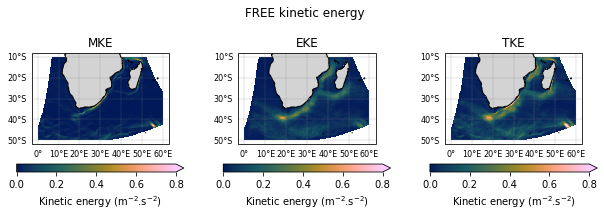

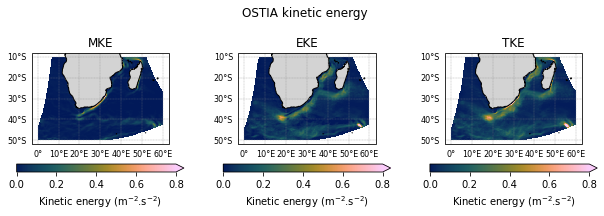

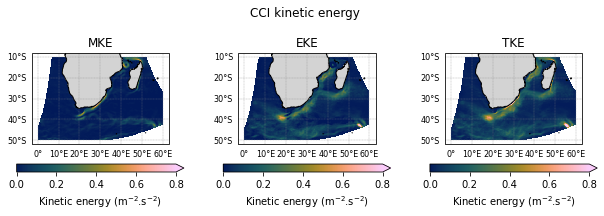

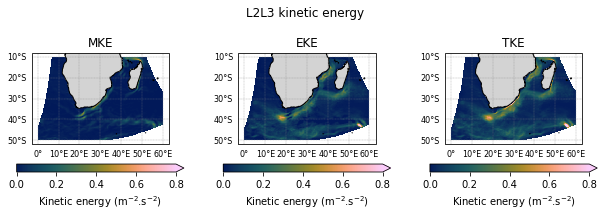

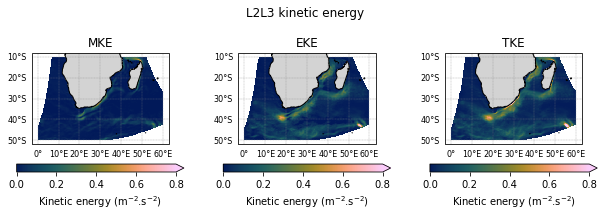

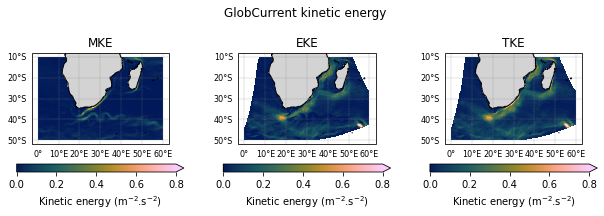

In [13]:
# plotEnergies(ds_cci, 'CCI')

sims = [(ds_free, 'FREE'), (ds_ostia, 'OSTIA'), (ds_cci, 'CCI'), (ds_l2l3, 'L2L3'),
        (ds_l2, 'L2L3'), (ds_gc, 'GlobCurrent')]

for run, name in sims:
    plotEnergies(run, name)

# HYCOM<sub>CCI</sub> vs HYCOM<sub>FREE</sub>

In [2]:
ds_free = xr.open_dataset('../Data/hycom_free_vel.nc')
ds_free = ds_free.sel(time=slice('2009-01-01','2014-06-04'))

ds_cci = xr.open_dataset('../Data/hycom_cci_vel.nc')
ds_cci = ds_cci.sel(time=slice('2009-01-01','2014-06-04'))

ds_cmems = xr.open_dataset('../Data/cmems_ssh.nc')
ds_cmems = ds_cmems.sel(time=slice('2009-01-01','2014-06-04'))

# diff = ds_cci - ds_free

In [5]:
ds_cmems

<xarray.Dataset>
Dimensions:    (latitude: 160, longitude: 240, nv: 2, time: 1981)
Coordinates:
  * latitude   (latitude) float32 -49.875 -49.625 -49.375 ... -10.375 -10.125
  * longitude  (longitude) float32 0.125 0.375 0.625 ... 59.375 59.625 59.875
  * nv         (nv) int32 0 1
  * time       (time) datetime64[ns] 2009-01-01 2009-01-02 ... 2014-06-04
Data variables:
    adt        (time, latitude, longitude) float64 ...
    crs        int32 ...
    err        (time, latitude, longitude) float64 ...
    lat_bnds   (latitude, nv) float32 ...
    lon_bnds   (longitude, nv) float32 ...
    sla        (time, latitude, longitude) float64 ...
    ugos       (time, latitude, longitude) float64 ...
    ugosa      (time, latitude, longitude) float64 ...
    vgos       (time, latitude, longitude) float64 ...
    vgosa      (time, latitude, longitude) float64 ...
Attributes:
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_d

## Mean & Eddy Kinetic Energy

### HYCOM<sub>FREE</sub>

In [3]:
# calculate mean zonal velocity and convert from m/s to cm/s
mean_u_free = ds_free['u'].mean(dim='time', skipna=True)
mean_u_free = mean_u_free * 100

# calculate mean meridional velocity and convert from m/s to cm/s
mean_v_free = ds_free['v'].mean(dim='time', skipna=True)
mean_v_free = mean_v_free * 100

# calculate mean kinetic energy
mke_free = 0.5*(np.square(mean_u_free) + np.square(mean_v_free))

/home/harry/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [ ]:
# calculate meridional and zonal velocity anomalies and convert from m/s to cm/s
eke_u_free = (ds_free['u'] * 100)-mean_u_free
eke_v_free = (ds_free['v'] * 100)-mean_v_free

# calculate eddy kinetic energy
eke_free = 0.5*(np.square(eke_u_free) + np.square(eke_v_free))

In [ ]:
eke

#### MKE

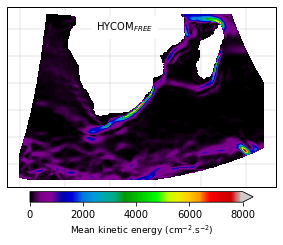

<Figure size 432x288 with 0 Axes>

In [18]:
# proj = ccrs.Orthographic(central_latitude=-32,central_longitude=35)
proj = ccrs.PlateCarree()

# plt.figure(figsize=(10,5))
plt.figure(figsize=(5,4))
ax = plt.axes(projection=proj)
# ax.stock_img()
ax.coastlines()
ax.gridlines(color='black', linewidth=0.1)
# ax.set_extent((0,60,-46.85,-10))

img = mke_free.plot(ax=ax, transform=ccrs.Mercator(), cmap=plt.get_cmap('nipy_spectral'), add_colorbar=False, vmin=0, vmax=8000)
cbar = plt.colorbar(img, shrink=0.8, extend='max', orientation='horizontal', pad=0.02)
cbar.set_label('Mean kinetic energy (cm$^{-2}$.s$^{-2}$)', fontsize=9)
ax.set_title('')
plt.text(0.33,0.87,'HYCOM$_{FREE}$', bbox=dict(facecolor='white', edgecolor='white', alpha=1), fontsize=10, transform=ax.transAxes)
plt.savefig('../Figures/vel/MKE_mean_HYCOMfree.png', dpi=300, bbox_inches='tight', format='png')
plt.show()
plt.tight_layout()

#### MKE Seasonal

In [51]:
# calculate mean zonal velocity and convert from m/s to cm/s
seasonal_u_free = ds_free['u'].groupby('time.season').mean(dim='time', skipna=True)
seasonal_u_free = seasonal_u_free * 100

# calculate mean meridional velocity and convert from m/s to cm/s
seasonal_v_free = ds_free['v'].groupby('time.season').mean(dim='time', skipna=True)
seasonal_v_free = seasonal_v_free * 100

# calculate mean kinetic energy
seasonal_mke_free = 0.5*(np.square(seasonal_u_free) + np.square(seasonal_v_free))

/home/harry/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


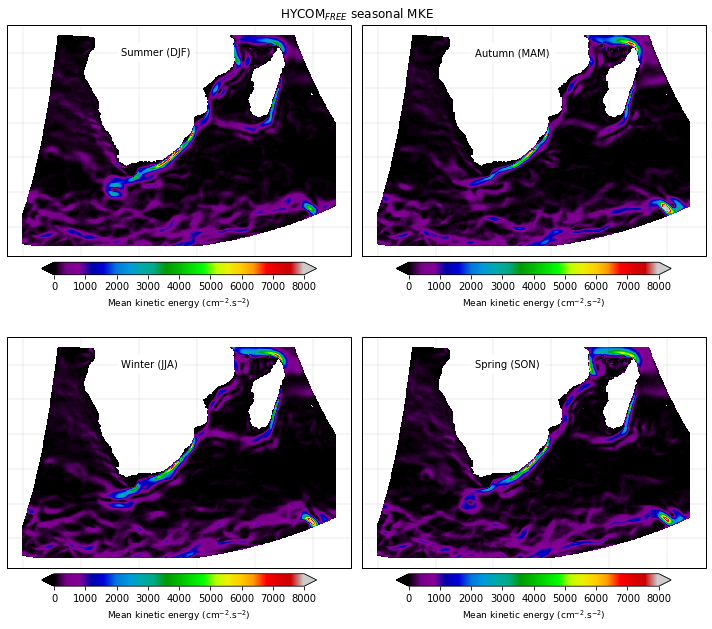

In [57]:
proj = ccrs.PlateCarree()
seasons = ['Summer (DJF)', 'Autumn (MAM)', 'Winter (JJA)', 'Spring (SON)']

fig = plt.figure(figsize=(10,9))
fig.suptitle('HYCOM$_{FREE}$ seasonal MKE')

for s, i in enumerate(seasons):
    
    ax = plt.subplot(2,2,s+1,projection=proj)
    
    img = seasonal_mke_free[s,0,:,:].plot(ax=ax, transform=ccrs.Mercator(), cmap=plt.get_cmap('nipy_spectral'), add_colorbar=False, vmin=0, vmax=8000)
    cbar = plt.colorbar(img, shrink=0.8, orientation='horizontal', extend='both', pad=0.02)
    cbar.set_label('Mean kinetic energy (cm$^{-2}$.s$^{-2}$)', fontsize=9)
    ax.gridlines(color='black', linewidth=0.1, linestyle='dashed')
    ax.text(0.33,0.87,'{0}'.format(i), bbox=dict(facecolor='white', edgecolor='white', alpha=1), fontsize=10, transform=ax.transAxes)
    ax.set_title('')
    
plt.plot()
fig.canvas.draw()
fig.tight_layout()

#### EKE

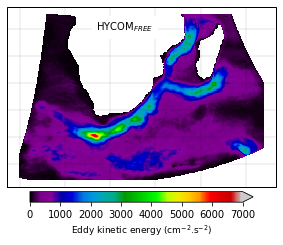

<Figure size 432x288 with 0 Axes>

In [31]:
# proj = ccrs.Orthographic(central_latitude=-32,central_longitude=35)
proj = ccrs.PlateCarree()

# plt.figure(figsize=(10,5))
plt.figure(figsize=(5,4))
ax = plt.axes(projection=proj)
# ax.stock_img()
ax.coastlines()
ax.gridlines(color='black', linewidth=0.1)
# ax.set_extent((0,60,-46.85,-10))

img = eke_free.mean(dim='time').plot(ax=ax, transform=ccrs.Mercator(), cmap=plt.get_cmap('nipy_spectral'), add_colorbar=False, vmin=0, vmax=7000)
cbar = plt.colorbar(img, shrink=0.8, extend='max', orientation='horizontal', pad=0.02)
cbar.set_label('Eddy kinetic energy (cm$^{-2}$.s$^{-2}$)', fontsize=9)
ax.set_title('')
plt.text(0.33,0.87,'HYCOM$_{FREE}$', bbox=dict(facecolor='white', edgecolor='white', alpha=1), fontsize=10, transform=ax.transAxes)
plt.savefig('../Figures/vel/EKE_mean_HYCOMfree.png', dpi=300, bbox_inches='tight', format='png')
plt.show()
plt.tight_layout()

#### EKE Seasonal

In [ ]:
# calculate meridional and zonal velocity anomalies and convert from m/s to cm/s
seasonal_eke_u_free = (ds_free['u'] * 100)-mean_u_free
seasonal_eke_v_free = (ds_free['v'] * 100)-mean_v_free

# calculate eddy kinetic energy
# seasonal_eke_free = 0.5*(np.square(seasonal_eke_u_free) + np.square(seasonal_eke_v_free))

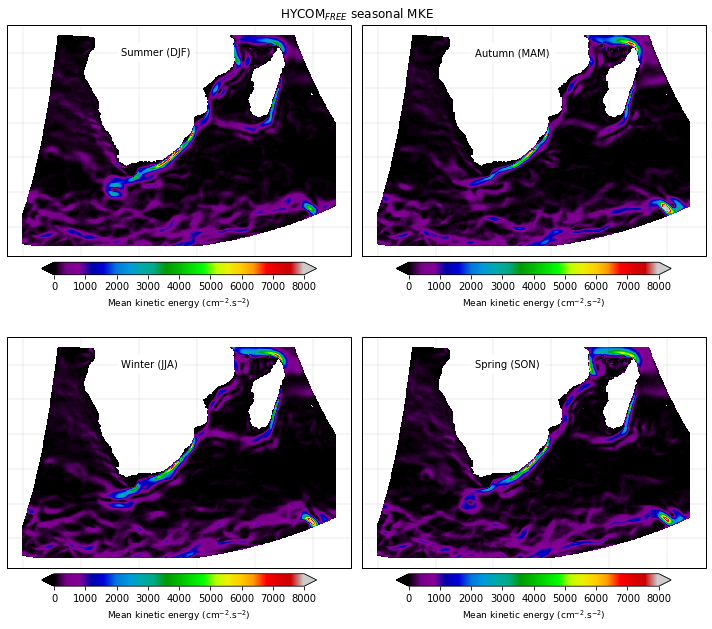

In [57]:
proj = ccrs.PlateCarree()
seasons = ['Summer (DJF)', 'Autumn (MAM)', 'Winter (JJA)', 'Spring (SON)']

fig = plt.figure(figsize=(10,9))
fig.suptitle('HYCOM$_{FREE}$ seasonal MKE')

for s, i in enumerate(seasons):
    
    ax = plt.subplot(2,2,s+1,projection=proj)
    
    img = seasonal_mke_free[s,0,:,:].plot(ax=ax, transform=ccrs.Mercator(), cmap=plt.get_cmap('nipy_spectral'), add_colorbar=False, vmin=0, vmax=8000)
    cbar = plt.colorbar(img, shrink=0.8, orientation='horizontal', extend='both', pad=0.02)
    cbar.set_label('Mean kinetic energy (cm$^{-2}$.s$^{-2}$)', fontsize=9)
    ax.gridlines(color='black', linewidth=0.1, linestyle='dashed')
    ax.text(0.33,0.87,'{0}'.format(i), bbox=dict(facecolor='white', edgecolor='white', alpha=1), fontsize=10, transform=ax.transAxes)
    ax.set_title('')
    
plt.plot()
fig.canvas.draw()
fig.tight_layout()

### HYCOM<sub>CCI</sub>

In [22]:
# calculate mean zonal velocity and convert from m/s to cm/s
mean_u_cci = ds_cci['u'].mean(dim='time', skipna=True)
mean_u_cci = mean_u_cci * 100

# calculate mean meridional velocity and convert from m/s to cm/s
mean_v_cci = ds_cci['v'].mean(dim='time', skipna=True)
mean_v_cci = mean_v_cci * 100

# calculate mean kinetic energy
mke_cci = 0.5*(np.square(mean_u_cci) + np.square(mean_v_cci))

/home/harry/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [23]:
# calculate meridional and zonal velocity anomalies and convert from m/s to cm/s
eke_u_cci = (ds_cci['u'] * 100)-mean_u_cci
eke_v_cci = (ds_cci['v'] * 100)-mean_v_cci

# calculate eddy kinetic energy
eke_cci = 0.5*(np.square(eke_u_cci) + np.square(eke_v_cci))

In [10]:
eke_cci

<xarray.DataArray (time: 1995, depth: 1, latitude: 444, longitude: 666)>
array([[[[nan, ..., nan],
         ...,
         [nan, ..., nan]]],


       ...,


       [[[nan, ..., nan],
         ...,
         [nan, ..., nan]]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2008-12-18 2008-12-19 ... 2014-06-04
  * longitude  (longitude) float32 0.0 0.09022556 0.18045112 ... 59.909775 60.0
  * latitude   (latitude) float32 -50.0 -49.93051 -49.86092 ... -10.10637 -10.0
  * depth      (depth) float32 5.0

#### MKE

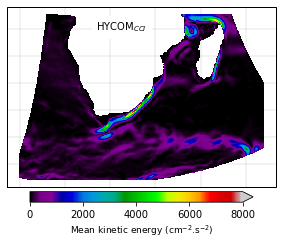

<Figure size 432x288 with 0 Axes>

In [32]:
# proj = ccrs.Orthographic(central_latitude=-32,central_longitude=35)
proj = ccrs.PlateCarree()

# plt.figure(figsize=(10,5))
plt.figure(figsize=(5,4))
ax = plt.axes(projection=proj)
# ax.stock_img()
ax.coastlines()
ax.gridlines(color='black', linewidth=0.1)
# ax.set_extent((0,60,-46.85,-10))

img = mke_cci.plot(ax=ax, transform=ccrs.Mercator(), cmap=plt.get_cmap('nipy_spectral'), add_colorbar=False, vmin=0, vmax=8000)
cbar = plt.colorbar(img, shrink=0.8, extend='max', orientation='horizontal', pad=0.02)
cbar.set_label('Mean kinetic energy (cm$^{-2}$.s$^{-2}$)', fontsize=9)
ax.set_title('')
plt.text(0.33,0.87,'HYCOM$_{CCI}$', bbox=dict(facecolor='white', edgecolor='white', alpha=1), fontsize=10, transform=ax.transAxes)
plt.savefig('../Figures/vel/MKE_mean_HYCOMcci.png', dpi=300, bbox_inches='tight', format='png')
plt.show()
plt.tight_layout()

#### EKE

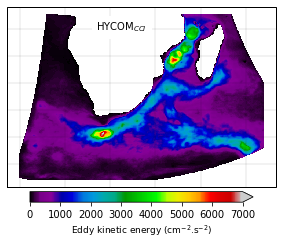

<Figure size 432x288 with 0 Axes>

In [33]:
# proj = ccrs.Orthographic(central_latitude=-32,central_longitude=35)
proj = ccrs.PlateCarree()

# plt.figure(figsize=(10,5))
plt.figure(figsize=(5,4))
ax = plt.axes(projection=proj)
# ax.stock_img()
ax.coastlines()
ax.gridlines(color='black', linewidth=0.1)
# ax.set_extent((0,60,-46.85,-10))

img = eke_cci.mean(dim='time').plot(ax=ax, transform=ccrs.Mercator(), cmap=plt.get_cmap('nipy_spectral'), add_colorbar=False, vmin=0, vmax=7000)
cbar = plt.colorbar(img, shrink=0.8, extend='max', orientation='horizontal', pad=0.02)
cbar.set_label('Eddy kinetic energy (cm$^{-2}$.s$^{-2}$)', fontsize=9)
ax.set_title('')
plt.text(0.33,0.87,'HYCOM$_{CCI}$', bbox=dict(facecolor='white', edgecolor='white', alpha=1), fontsize=10, transform=ax.transAxes)
plt.savefig('../Figures/vel/EKE_mean_HYCOMcci.png', dpi=300, bbox_inches='tight', format='png')
plt.show()
plt.tight_layout()

### CMEMS

In [6]:
# calculate mean zonal velocity and convert from m/s to cm/s
mean_u_cmems = ds_cmems['ugos'].mean(dim='time', skipna=True)
mean_u_cmems = mean_u_cmems * 100

# calculate mean meridional velocity and convert from m/s to cm/s
mean_v_cmems = ds_cmems['vgos'].mean(dim='time', skipna=True)
mean_v_cmems = mean_v_cmems * 100

# calculate mean kinetic energy
mke_cmems = 0.5*(np.square(mean_u_cmems) + np.square(mean_v_cmems))

/home/harry/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [7]:
# calculate meridional and zonal velocity anomalies and convert from m/s to cm/s
eke_u_cmems = (ds_cmems['ugos'] * 100)-mean_u_cmems
eke_v_cmems = (ds_cmems['vgos'] * 100)-mean_v_cmems

# calculate eddy kinetic energy
eke_cmems = 0.5*(np.square(eke_u_cmems) + np.square(eke_v_cmems))

#### MKE

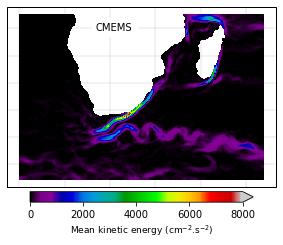

<Figure size 432x288 with 0 Axes>

In [8]:
# proj = ccrs.Orthographic(central_latitude=-32,central_longitude=35)
proj = ccrs.PlateCarree()

# plt.figure(figsize=(10,5))
plt.figure(figsize=(5,4))
ax = plt.axes(projection=proj)
# ax.stock_img()
ax.coastlines()
ax.gridlines(color='black', linewidth=0.1)
# ax.set_extent((0,60,-46.85,-10))

img = mke_cmems.plot(ax=ax, transform=ccrs.Mercator(), cmap=plt.get_cmap('nipy_spectral'), add_colorbar=False, vmin=0, vmax=8000)
cbar = plt.colorbar(img, shrink=0.8, extend='max', orientation='horizontal', pad=0.02)
cbar.set_label('Mean kinetic energy (cm$^{-2}$.s$^{-2}$)', fontsize=9)
ax.set_title('')
plt.text(0.33,0.87,'CMEMS', bbox=dict(facecolor='white', edgecolor='white', alpha=1), fontsize=10, transform=ax.transAxes)
plt.savefig('../Figures/vel/MKE_mean_CMEMS.png', dpi=300, bbox_inches='tight', format='png')
plt.show()
plt.tight_layout()

#### EKE

/home/harry/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


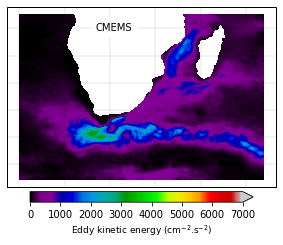

<Figure size 432x288 with 0 Axes>

In [9]:
# proj = ccrs.Orthographic(central_latitude=-32,central_longitude=35)
proj = ccrs.PlateCarree()

# plt.figure(figsize=(10,5))
plt.figure(figsize=(5,4))
ax = plt.axes(projection=proj)
# ax.stock_img()
ax.coastlines()
ax.gridlines(color='black', linewidth=0.1)
# ax.set_extent((0,60,-46.85,-10))

img = eke_cmems.mean(dim='time').plot(ax=ax, transform=ccrs.Mercator(), cmap=plt.get_cmap('nipy_spectral'), add_colorbar=False, vmin=0, vmax=7000)
cbar = plt.colorbar(img, shrink=0.8, extend='max', orientation='horizontal', pad=0.02)
cbar.set_label('Eddy kinetic energy (cm$^{-2}$.s$^{-2}$)', fontsize=9)
ax.set_title('')
plt.text(0.33,0.87,'CMEMS', bbox=dict(facecolor='white', edgecolor='white', alpha=1), fontsize=10, transform=ax.transAxes)
plt.savefig('../Figures/vel/EKE_mean_CMEMS.png', dpi=300, bbox_inches='tight', format='png')
plt.show()
plt.tight_layout()

### Difference (HYCOM<sub>CCI</sub> - HYCOM<sub>FREE</sub>)

#### MKE

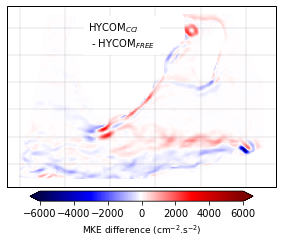

<Figure size 432x288 with 0 Axes>

In [34]:
# proj = ccrs.Orthographic(central_latitude=-32,central_longitude=35)
proj = ccrs.PlateCarree()

mke_diff = mke_cci - mke_free

# plt.figure(figsize=(10,5))
plt.figure(figsize=(5,4))
ax = plt.axes(projection=proj)
# ax.stock_img()
ax.coastlines()
ax.gridlines(color='black', linewidth=0.1)
# ax.set_extent((0,60,-46.85,-10))

img = mke_diff.plot(ax=ax, transform=ccrs.Mercator(), cmap=plt.get_cmap('seismic'), add_colorbar=False, vmin=-6000, vmax=6000)
cbar = plt.colorbar(img, shrink=0.8, extend='both', orientation='horizontal', pad=0.02)
cbar.set_label('MKE difference (cm$^{-2}$.s$^{-2}$)', fontsize=9)
ax.set_title('')
plt.text(0.30,0.78,'HYCOM$_{CCI}$\n - HYCOM$_{FREE}$', bbox=dict(facecolor='white', edgecolor='white', alpha=1), fontsize=10, transform=ax.transAxes)
plt.savefig('../Figures/vel/MKE_meandiff_HYCOMcciHYCOMfree.png', dpi=300, bbox_inches='tight', format='png')
plt.show()
plt.tight_layout()

#### EKE

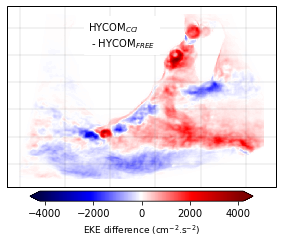

<Figure size 432x288 with 0 Axes>

In [38]:
# proj = ccrs.Orthographic(central_latitude=-32,central_longitude=35)
proj = ccrs.PlateCarree()

eke_diff = eke_cci - eke_free

# plt.figure(figsize=(10,5))
plt.figure(figsize=(5,4))
ax = plt.axes(projection=proj)
# ax.stock_img()
ax.coastlines()
ax.gridlines(color='black', linewidth=0.1)
# ax.set_extent((0,60,-46.85,-10))

img = eke_diff.mean(dim='time').plot(ax=ax, transform=ccrs.Mercator(), cmap=plt.get_cmap('seismic'), add_colorbar=False, vmin=-4200, vmax=4200)
cbar = plt.colorbar(img, shrink=0.8, extend='both', orientation='horizontal', pad=0.02)
cbar.set_label('EKE difference (cm$^{-2}$.s$^{-2}$)', fontsize=9)
ax.set_title('')
plt.text(0.30,0.78,'HYCOM$_{CCI}$\n - HYCOM$_{FREE}$', bbox=dict(facecolor='white', edgecolor='white', alpha=1), fontsize=10, transform=ax.transAxes)
plt.savefig('../Figures/vel/EKE_meandiff_HYCOMcciHYCOMfree.png', dpi=300, bbox_inches='tight', format='png')
plt.show()
plt.tight_layout()

## Velocities

### HYCOM<sub>FREE</sub>

ValueError: x, y, u and v arrays must be the same shape

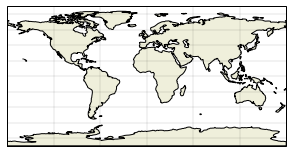

In [42]:
# proj = ccrs.Orthographic(central_latitude=-32,central_longitude=35)
proj = ccrs.PlateCarree()

# plt.figure(figsize=(10,5))
plt.figure(figsize=(5,4))
ax = plt.axes(projection=proj)
# ax.stock_img()
# ax.coastlines()
ax.gridlines(color='black', linewidth=0.1)
# ax.set_extent((0,60,-46.85,-10))

ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')

ax.quiver(ds_free['longitude'].values, ds_free['latitude'].values, ds_free['u'][:,0,:,:].values, ds_free['v'][:,0,:,:].values, transform=ccrs.Mercator())

# img = mke_free.plot(ax=ax, transform=ccrs.Mercator(), cmap=plt.get_cmap('nipy_spectral'), add_colorbar=False, vmin=0, vmax=8000)
# cbar = plt.colorbar(img, shrink=0.8, extend='max', orientation='horizontal', pad=0.02)
# cbar.set_label('Mean kinetic energy (cm$^{-2}$.s$^{-2}$)', fontsize=9)
ax.set_title('')
plt.text(0.33,0.87,'HYCOM$_{FREE}$', bbox=dict(facecolor='white', edgecolor='white', alpha=1), fontsize=10, transform=ax.transAxes)
# plt.savefig('../Figures/vel/MKE_mean_HYCOMfree.png', dpi=300, bbox_inches='tight', format='png')
plt.show()
plt.tight_layout()

In [36]:
ds_free['u'][:,0,:,:].shape

(1981, 444, 666)

# Timeseries

In [25]:
# Agulhas region
#=====================================================================================================================================

# Port Shepstone current core
ps_free = ds_free.sel(latitude=slice(-31.23,-30.09),longitude=slice(30.39,30.62)).mean(dim=('longitude','latitude'), skipna=True)
ps_cci = ds_cci.sel(latitude=slice(-31.23,-30.09),longitude=slice(30.39,30.62)).mean(dim=('longitude','latitude'), skipna=True)
ps_cmems = ds_cmems.sel(latitude=slice(-31.23,-30.09),longitude=slice(30.39,30.62)).mean(dim=('longitude','latitude'), skipna=True)

# Port Elizabeth current core
pe_free = ds_free.sel(latitude=slice(-34.63,-34.49),longitude=slice(25.77,26.00)).mean(dim=('longitude','latitude'), skipna=True)
pe_cci = ds_cci.sel(latitude=slice(-34.63,-34.49),longitude=slice(25.77,26.00)).mean(dim=('longitude','latitude'), skipna=True)
pe_cmems = ds_cmems.sel(latitude=slice(-34.63,-34.49),longitude=slice(25.77,26.00)).mean(dim=('longitude','latitude'), skipna=True)

# Retroflection
ret_free = ds_free.sel(latitude=slice(-39.24,-39.10),longitude=slice(20.28,20.51)).mean(dim=('longitude','latitude'), skipna=True)
ret_cci = ds_cci.sel(latitude=slice(-39.24,-39.10),longitude=slice(20.28,20.51)).mean(dim=('longitude','latitude'), skipna=True)
ret_cmems = ds_cmems.sel(latitude=slice(-39.24,-39.10),longitude=slice(20.28,20.51)).mean(dim=('longitude','latitude'), skipna=True)

# Agulhas Plateau loop
apl_free = ds_free.sel(latitude=slice(-38.31,-38.17),longitude=slice(26.27,26.50)).mean(dim=('longitude','latitude'), skipna=True)
apl_cci = ds_cci.sel(latitude=slice(-38.31,-38.17),longitude=slice(26.27,26.50)).mean(dim=('longitude','latitude'), skipna=True)
apl_cmems = ds_cmems.sel(latitude=slice(-38.31,-38.17),longitude=slice(26.27,26.50)).mean(dim=('longitude','latitude'), skipna=True)

# Agulhas Bank
aba_free = ds_free.sel(latitude=slice(-35.21,-35.07),longitude=slice(21.05,21.28)).mean(dim=('longitude','latitude'), skipna=True)
aba_cci = ds_cci.sel(latitude=slice(-35.21,-35.07),longitude=slice(21.05,21.28)).mean(dim=('longitude','latitude'), skipna=True)
aba_cmems = ds_cmems.sel(latitude=slice(-35.21,-35.07),longitude=slice(21.05,21.28)).mean(dim=('longitude','latitude'), skipna=True)


/home/harry/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [26]:
ps_cmems

<xarray.DataArray (time: 1981)>
array([nan, nan, nan, ..., nan, nan, nan])
Coordinates:
  * time     (time) datetime64[ns] 2009-01-01 2009-01-02 ... 2014-06-04

### Port Shepstone current core

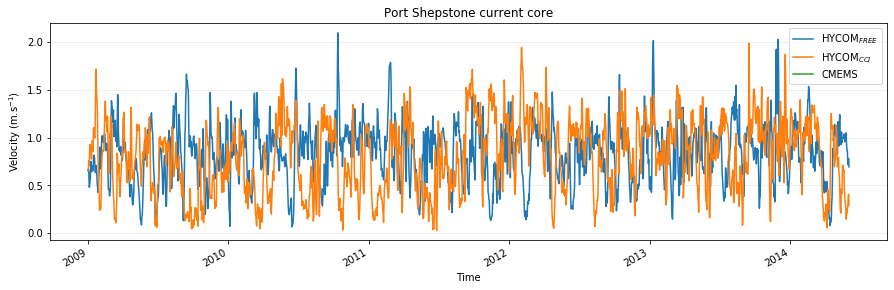

In [29]:
plt.figure(figsize=(15,4))

ps_free = np.sqrt(np.square(ps_free['v']) + np.square(ps_free['u']))
ps_cci = np.sqrt(np.square(ps_cci['v']) + np.square(ps_cci['u']))
ps_cmems = np.sqrt(np.square(ps_cmems['vgos']) + np.square(ps_cmems['ugos']))

ps_free.plot.line(x='time',label='HYCOM$_{FREE}$')
ps_cci.plot.line(x='time',label='HYCOM$_{CCI}$')
ps_cmems.plot.line(x='time',label='CMEMS')
plt.title('Port Shepstone current core')
plt.ylabel('Velocity (m.s$^{-1}$)')
plt.xlabel('Time')
plt.grid(axis='y', alpha=0.25)
plt.legend()

### Port Elizabeth current core

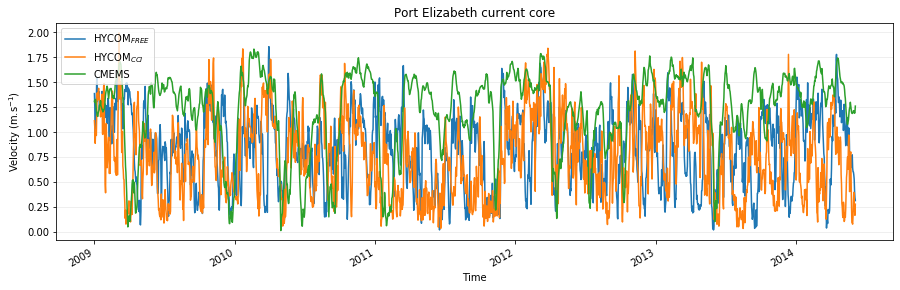

In [30]:
plt.figure(figsize=(15,4))

pe_free = np.sqrt(np.square(pe_free['v']) + np.square(pe_free['u']))
pe_cci = np.sqrt(np.square(pe_cci['v']) + np.square(pe_cci['u']))
pe_cmems = np.sqrt(np.square(pe_cmems['vgos']) + np.square(pe_cmems['ugos']))

pe_free.plot.line(x='time',label='HYCOM$_{FREE}$')
pe_cci.plot.line(x='time',label='HYCOM$_{CCI}$')
pe_cmems.plot.line(x='time',label='CMEMS')
plt.title('Port Elizabeth current core')
plt.ylabel('Velocity (m.s$^{-1}$)')
plt.xlabel('Time')
plt.grid(axis='y', alpha=0.25)
plt.legend()

### Agulhas retroflection

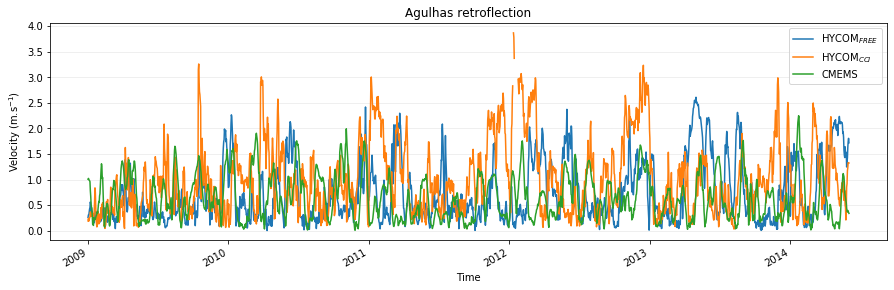

In [31]:
plt.figure(figsize=(15,4))

ret_free = np.sqrt(np.square(ret_free['v']) + np.square(ret_free['u']))
ret_cci = np.sqrt(np.square(ret_cci['v']) + np.square(ret_cci['u']))
ret_cmems = np.sqrt(np.square(ret_cmems['vgos']) + np.square(ret_cmems['ugos']))

ret_free.plot.line(x='time',label='HYCOM$_{FREE}$')
ret_cci.plot.line(x='time',label='HYCOM$_{CCI}$')
ret_cmems.plot.line(x='time',label='CMEMS')
plt.title('Agulhas retroflection')
plt.ylabel('Velocity (m.s$^{-1}$)')
plt.xlabel('Time')
plt.grid(axis='y', alpha=0.25)
plt.legend()

### Agulhas Plateau loop

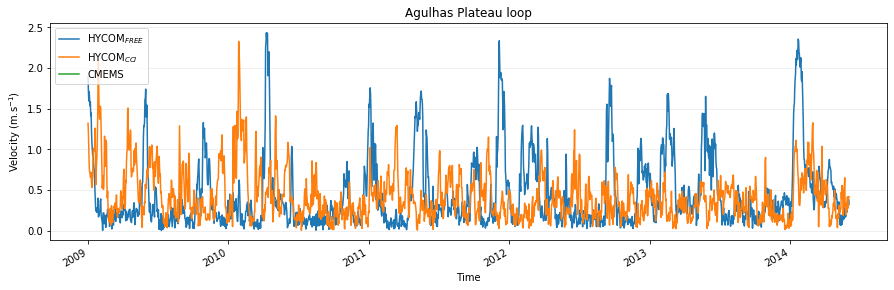

In [32]:
plt.figure(figsize=(15,4))

apl_free = np.sqrt(np.square(apl_free['v']) + np.square(apl_free['u']))
apl_cci = np.sqrt(np.square(apl_cci['v']) + np.square(apl_cci['u']))
apl_cmems = np.sqrt(np.square(apl_cmems['vgos']) + np.square(apl_cmems['ugos']))

apl_free.plot.line(x='time',label='HYCOM$_{FREE}$')
apl_cci.plot.line(x='time',label='HYCOM$_{CCI}$')
apl_cmems.plot.line(x='time',label='CMEMS')
plt.title('Agulhas Plateau loop')
plt.ylabel('Velocity (m.s$^{-1}$)')
plt.xlabel('Time')
plt.grid(axis='y', alpha=0.25)
plt.legend()

### Agulhas Bank

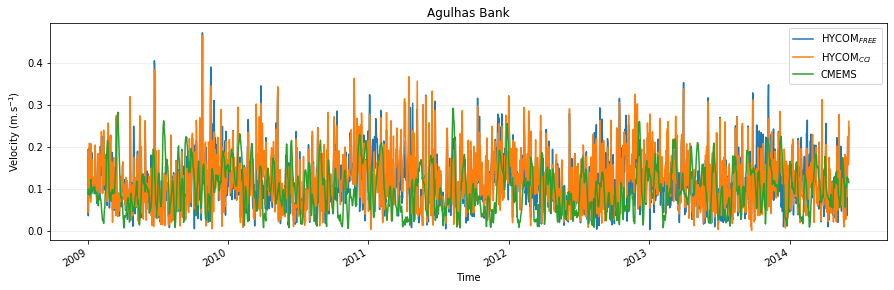

In [22]:
plt.figure(figsize=(15,4))

aba_free = np.sqrt(np.square(aba_free['v']) + np.square(aba_free['u']))
aba_cci = np.sqrt(np.square(aba_cci['v']) + np.square(aba_cci['u']))
aba_cmems = np.sqrt(np.square(aba_cmems['vgos']) + np.square(aba_cmems['ugos']))

aba_free.plot.line(x='time',label='HYCOM$_{FREE}$')
aba_cci.plot.line(x='time',label='HYCOM$_{CCI}$')
aba_cmems.plot.line(x='time',label='CMEMS')
plt.title('Agulhas Bank')
plt.ylabel('Velocity (m.s$^{-1}$)')
plt.xlabel('Time')
plt.grid(axis='y', alpha=0.25)
plt.legend()

### Port Shepstone current core

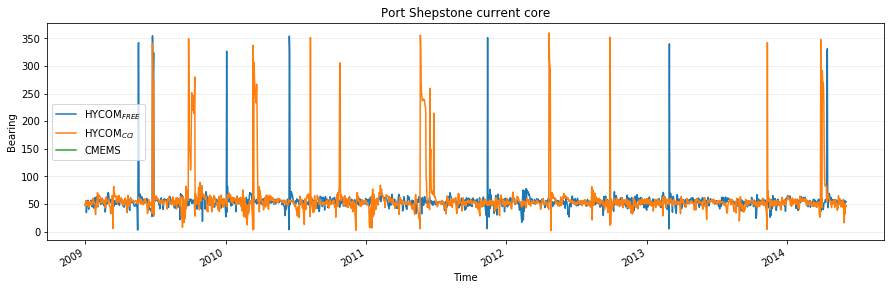

In [26]:
plt.figure(figsize=(15,4))

ps_free = np.degrees(np.arctan2(ps_free['v'].values,ps_free['u'])) + 180
ps_cci = np.degrees(np.arctan2(ps_cci['v'],ps_cci['u'])) + 180
ps_cmems = np.degrees(np.arctan2(ps_cmems['vgos'],ps_cmems['ugos'])) + 180

ps_free.plot.line(x='time',label='HYCOM$_{FREE}$')
ps_cci.plot.line(x='time',label='HYCOM$_{CCI}$')
ps_cmems.plot.line(x='time',label='CMEMS')
plt.title('Port Shepstone current core')
plt.ylabel('Bearing')
plt.xlabel('Time')
plt.grid(axis='y', alpha=0.25)
plt.legend()

### Port Elizabeth current core

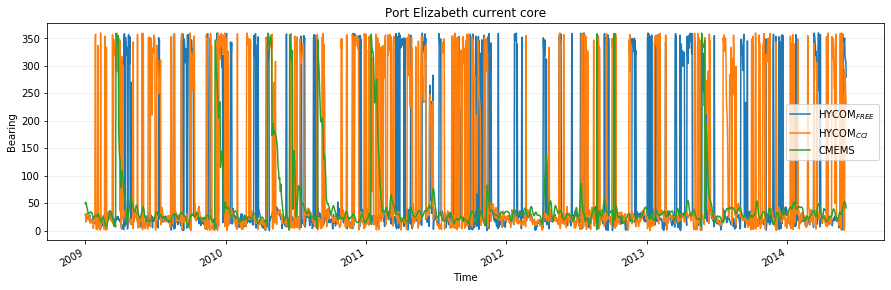

In [27]:
plt.figure(figsize=(15,4))

pe_free = np.degrees(np.arctan2(pe_free['v'].values,pe_free['u'])) + 180
pe_cci = np.degrees(np.arctan2(pe_cci['v'],pe_cci['u'])) + 180
pe_cmems = np.degrees(np.arctan2(pe_cmems['vgos'],pe_cmems['ugos'])) + 180

pe_free.plot.line(x='time',label='HYCOM$_{FREE}$')
pe_cci.plot.line(x='time',label='HYCOM$_{CCI}$')
pe_cmems.plot.line(x='time',label='CMEMS')
plt.title('Port Elizabeth current core')
plt.ylabel('Bearing')
plt.xlabel('Time')
plt.grid(axis='y', alpha=0.25)
plt.legend()

### Agulhas retroflection

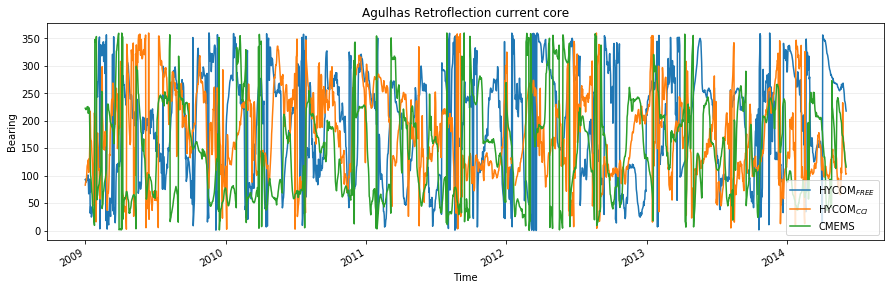

In [28]:
plt.figure(figsize=(15,4))

ret_free = np.degrees(np.arctan2(ret_free['v'].values,ret_free['u'])) + 180
ret_cci = np.degrees(np.arctan2(ret_cci['v'],ret_cci['u'])) + 180
ret_cmems = np.degrees(np.arctan2(ret_cmems['vgos'],ret_cmems['ugos'])) + 180

ret_free.plot.line(x='time',label='HYCOM$_{FREE}$')
ret_cci.plot.line(x='time',label='HYCOM$_{CCI}$')
ret_cmems.plot.line(x='time',label='CMEMS')
plt.title('Agulhas Retroflection current core')
plt.ylabel('Bearing')
plt.xlabel('Time')
plt.grid(axis='y', alpha=0.25)
plt.legend()

### Agulhas Plateau loop

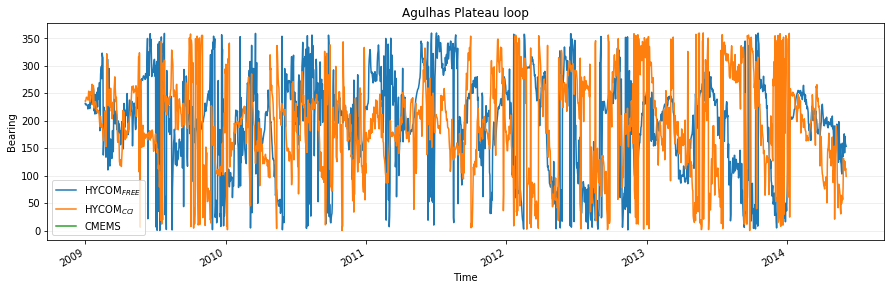

In [29]:
plt.figure(figsize=(15,4))

apl_free = np.degrees(np.arctan2(apl_free['v'].values,apl_free['u'])) + 180
apl_cci = np.degrees(np.arctan2(apl_cci['v'],apl_cci['u'])) + 180
apl_cmems = np.degrees(np.arctan2(apl_cmems['vgos'],apl_cmems['ugos'])) + 180

apl_free.plot.line(x='time',label='HYCOM$_{FREE}$')
apl_cci.plot.line(x='time',label='HYCOM$_{CCI}$')
apl_cmems.plot.line(x='time',label='CMEMS')
plt.title('Agulhas Plateau loop')
plt.ylabel('Bearing')
plt.xlabel('Time')
plt.grid(axis='y', alpha=0.25)
plt.legend()

### Agulhas Bank

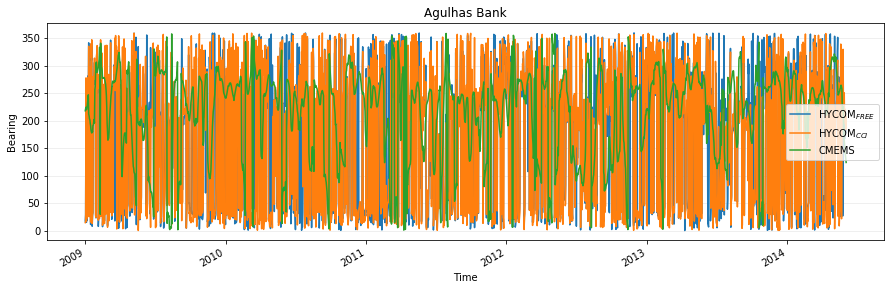

In [30]:
plt.figure(figsize=(15,4))

aba_free = np.degrees(np.arctan2(aba_free['v'].values,aba_free['u'])) + 180
aba_cci = np.degrees(np.arctan2(aba_cci['v'],aba_cci['u'])) + 180
aba_cmems = np.degrees(np.arctan2(aba_cmems['vgos'],aba_cmems['ugos'])) + 180

aba_free.plot.line(x='time',label='HYCOM$_{FREE}$')
aba_cci.plot.line(x='time',label='HYCOM$_{CCI}$')
aba_cmems.plot.line(x='time',label='CMEMS')
plt.title('Agulhas Bank')
plt.ylabel('Bearing')
plt.xlabel('Time')
plt.grid(axis='y', alpha=0.25)
plt.legend()

## HYCOM<sub>FREE</sub>

/home/harry/miniconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


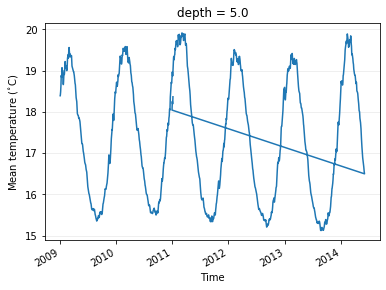

In [5]:
ds_free_timeseries['temperature'].plot()
plt.ylabel('Mean temperature ($^{\circ}$C)')
plt.xlabel('Time')
plt.grid(axis='y', alpha=0.25)

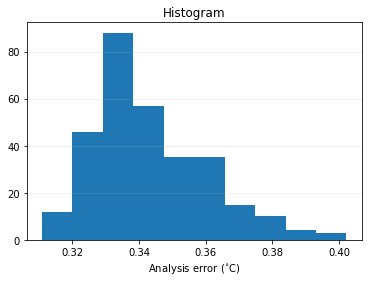

In [42]:
CCI_timeseries.plot.hist()
plt.xlabel('Analysis error ($^{\circ}$C)')
plt.grid(axis='y', alpha=0.25)

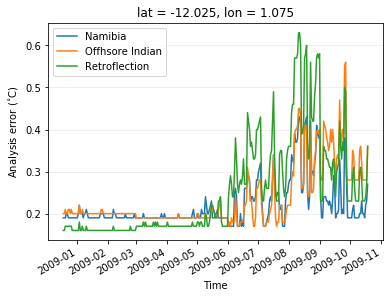

In [8]:
CCI.analysis_uncertainty.isel(lon=11, lat=-17).plot.line(x='time', label='Namibia')
CCI.analysis_uncertainty.isel(lon=37, lat=-39).plot.line(x='time', label='Offhsore Indian')
CCI.analysis_uncertainty.isel(lon=21, lat=-41).plot.line(x='time', label='Retroflection')
plt.ylabel('Analysis error ($^{\circ}$C)')
plt.xlabel('Time')
plt.grid(axis='y', alpha=0.25)
plt.legend()

## HYCOM<sub>CCI</sub>

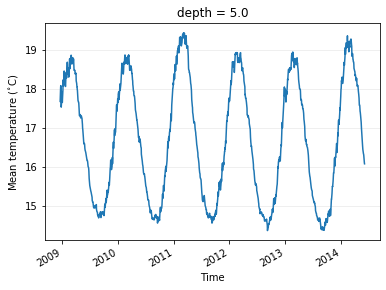

In [21]:
ds_cci_timeseries['temperature'].plot()
plt.ylabel('Mean temperature ($^{\circ}$C)')
plt.xlabel('Time')
plt.grid(axis='y', alpha=0.25)

#### Rolling mean test

In [27]:
# create rolling mean
# ds_cci_timeseries['temperature']

# cci_temp_rolling = ds_cci.rolling(time=365, center=True).mean(dim=('longitude','latitude'), skipna=True)
cci_temp_rolling = ds_cci_timeseries['temperature'].rolling(time=365, center=True).mean()

In [17]:
ds_cci_timeseries

<xarray.Dataset>
Dimensions:      (depth: 1, time: 1995)
Coordinates:
  * time         (time) datetime64[ns] 2008-12-18 2008-12-19 ... 2014-06-04
  * depth        (depth) float32 5.0
Data variables:
    mercator     float64 -2.147e+09
    x            float32 30.0
    y            float32 -0.59305453
    model_depth  float32 3870.213
    temperature  (time, depth) float32 17.684162 17.81782 ... 16.106533 16.08207
    u            (time, depth) float32 0.04220993 0.05429556 ... 0.035968564
    v            (time, depth) float32 -0.017690849 -0.008690205 ... 0.019931216
    ssh          (time) float32 0.27091807 0.2804947 ... 0.21975167 0.21528742

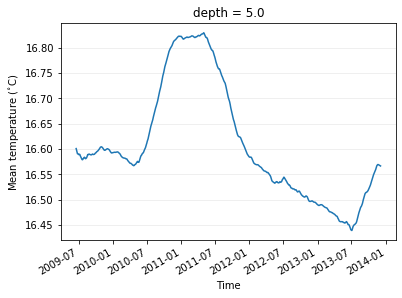

In [28]:
# cci_temp_rolling = ds_cci_timeseries['temperature'].rolling(time=365, center=True)
cci_temp_rolling.plot()
plt.ylabel('Mean temperature ($^{\circ}$C)')
plt.xlabel('Time')
plt.grid(axis='y', alpha=0.25)

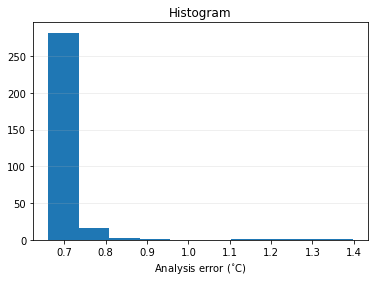

In [45]:
OSTIA_timeseries.plot.hist()
plt.xlabel('Analysis error ($^{\circ}$C)')
plt.grid(axis='y', alpha=0.25)

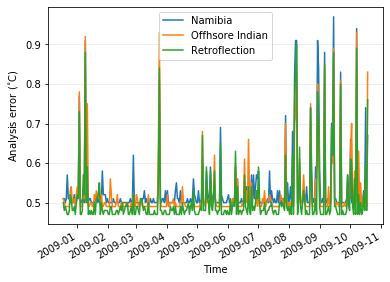

In [46]:
OSTIA.analysis_error.isel(lon=11, lat=-17).plot.line(x='time', label='Namibia')
OSTIA.analysis_error.isel(lon=37, lat=-39).plot.line(x='time', label='Offhsore Indian')
OSTIA.analysis_error.isel(lon=21, lat=-41).plot.line(x='time', label='Retroflection')
plt.ylabel('Analysis error ($^{\circ}$C)')
plt.xlabel('Time')
plt.grid(axis='y', alpha=0.25)
plt.legend()

## CCI vs OSTIA

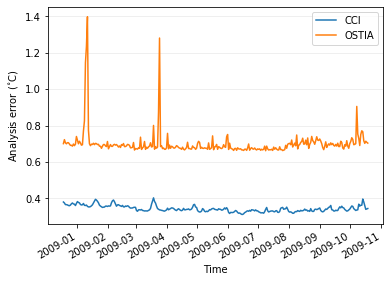

In [6]:
CCI_timeseries.plot(label='CCI')
OSTIA_timeseries.plot(label='OSTIA')
plt.ylabel('Analysis error ($^{\circ}$C)')
plt.xlabel('Time')
plt.grid(axis='y', alpha=0.25)
plt.legend()
plt.savefig('CCIvsOSTIA_timeseries.png', dpi=300, bbox_inches='tight', format='png')

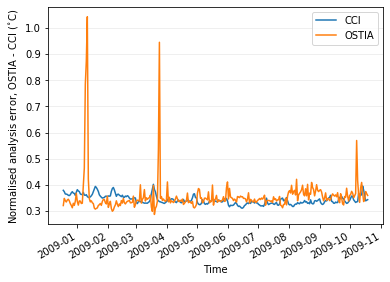

In [7]:
CCI_timeseries.plot(label='CCI')
Normalised_OSTIA.plot(label='OSTIA')
plt.ylabel('Normalised analysis error, OSTIA - CCI ($^{\circ}$C)')
plt.xlabel('Time')
plt.grid(axis='y', alpha=0.25)
plt.legend()

In [18]:
xr.decode_cf(CCI)

<xarray.Dataset>
Dimensions:               (lat: 801, lon: 1200, time: 305)
Coordinates:
  * time                  (time) datetime64[ns] 2008-12-18T12:00:00 ... 2009-10-18T12:00:00
  * lat                   (lat) float32 -50.025 -49.975 ... -10.075 -10.025
  * lon                   (lon) float32 0.025 0.075 0.125 ... 59.925 59.975
Data variables:
    analysis_uncertainty  (time, lat, lon) float32 ...
Attributes:
    Conventions:                     CF-1.5, Unidata Observation Dataset v1.0
    title:                           ESA SST CCI OSTIA L4 product
    summary:                         OSTIA L4 product from the ESA SST CCI pr...
    references:                      http://www.esa-sst-cci.org
    institution:                     ESACCI
    history:                         Created using OSTIA reanalysis system v3.0
    comment:                         These data were produced at the Met Offi...
    license:                         Creative Commons Licence by attribution ...
    id:  